In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

from data_handling import load_measurements_txt, MeasurementDataset, MeasurementLoader


import csv
import math

from typing import Any, Callable, Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_merge/tfim_renyi/measurements


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim

        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))

    def forward(self, cond: torch.Tensor):
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)
        elif cond.dim() == 2 and cond.size(1) == self.cond_dim:
            pass
        else:
            raise ValueError(f"Conditioner: expected shape (B, {self.cond_dim}), got {tuple(cond.shape)}")

        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)

        N, H = self.num_visible, self.num_hidden
        gamma_b, beta_b, gamma_c, beta_c = torch.split(x, [N, N, H, H], dim=-1)
        return gamma_b, beta_b, gamma_c, beta_c


class ConditionalRBM(nn.Module):
    """
    Conditional RBM with per-sample conditioning vector.

    Batch format from MeasurementLoader:
        values        : (B, N) uint8
        bases         : list[Tuple[str,...]]  (ignored here, but available)
        system_params : (B, cond_dim) float32
    """
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        nn.init.normal_(self.W, mean=0.0, std=0.01)

        self.conditioner = Conditioner(num_visible=num_visible, num_hidden=num_hidden,
                                       cond_dim=cond_dim,hidden_width=conditioner_width)

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        if b.dim() == 1:
            b = b.unsqueeze(0).expand_as(v)
        h_arg = v @ W
        if c.dim() == 1:
            c = c.unsqueeze(0).expand(h_arg.shape[0], -1)

        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(h_arg + c).sum(dim=-1)
        return term1 - term2

    # there has to be a readymade torch function for this
    @staticmethod
    def _sample_bernoulli(probs: torch.Tensor, gen: torch.Generator) -> torch.Tensor:
        noise = torch.rand(probs.shape, generator=gen, device=probs.device, dtype=probs.dtype)
        return (noise < probs).to(probs.dtype)

    def _gibbs_step_T(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, gen: torch.Generator):
        # Sample h | v
        logits_h = (v @ self.W + c_mod) / T
        p_h = torch.sigmoid(logits_h)
        h = self._sample_bernoulli(p_h, gen)

        # Sample v | h
        logits_v = (h @ self.W.t() + b_mod) / T
        p_v = torch.sigmoid(logits_v)
        v = self._sample_bernoulli(p_v, gen)
        return v

    # maybe split up the batch such that it has not such an ugly type
    def forward(self, batch: Tuple[torch.Tensor, List[Tuple[str, ...]], Optional[torch.Tensor]], aux_vars: Dict[str, Any]):
        """
        batch:
            values        : (B, N), uint8
            bases         : list[Tuple[str,...]]  (ignored)
            system_params : (B, cond_dim), float32

        aux_vars:
            gen          : torch.Generator for Gibbs sampling
            l2_strength  : float, L2 penalty on deviation (b_mod, c_mod) from base (b, c)
        """
        values, bases, cond = batch  # bases currently unused

        if cond is None:
            raise ValueError("ConditionalRBM expects non-None system_params as conditioning vector.")

        gen: torch.Generator = aux_vars.get("gen", torch.Generator().manual_seed(0))
        l2_strength: float = float(aux_vars.get("l2_strength", 0.0))

        v_data = values.float()
        cond = cond.to(v_data.device, dtype=v_data.dtype)

        # query the conditioner for bias over the batch of samples
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c

        # penalize conditioner for changing biases too much
        l2_regularization = (self.b.unsqueeze(0) - b_mod).pow(2).sum() + (self.c.unsqueeze(0) - c_mod).pow(2).sum()

        # negative phase gibbs chain, we start from random noise, so no PCD here!
        v_model = (torch.rand(v_data.shape, generator=gen, device=v_data.device) < 0.5).float()
        for _ in range(self.k):
            v_model = self._gibbs_step_T(v_model, b_mod, c_mod, self.T, gen)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)
        fe_delta = fe_data - fe_model

        fe_mean = fe_delta.mean()                   # loss signal is mean over batch
        fe_std = fe_delta.std(unbiased=False)
        aux_out = { "free_energy_mean": fe_mean.detach(), "free_energy_std": fe_std.detach() }

        loss = fe_mean + l2_strength * l2_regularization

        return loss, aux_out

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, T_schedule: torch.Tensor, gen: torch.Generator) -> torch.Tensor:
        """
        Generate samples given conditioning vector(s).

        IMPORTANT: The batch size of cond determines the batch size of samples.

        cond       : (B, cond_dim)
        T_schedule : scalar or (K,) schedule
        """
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)
        cond = cond.to(next(self.parameters()).device, dtype=torch.float32)

        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c

        B = cond.shape[0]
        v = (torch.rand((B, self.num_visible), generator=gen, device=cond.device) < 0.5).float()

        if T_schedule.dim() == 0:
            T_schedule = T_schedule.view(1)

        for i in range(int(T_schedule.shape[0])):
            T_i = float(T_schedule[i].item())
            v = self._gibbs_step_T(v, b_mod, c_mod, T_i, gen)

        return v

In [3]:
def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch: Tuple[torch.Tensor, List[Tuple[str, ...]], Optional[torch.Tensor]], aux_vars: Dict[str, Any]):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux


def train(model: nn.Module, optimizer: torch.optim.Optimizer, loader, num_epochs: int,
          gen: torch.Generator, l2_strength: float, lr_schedule_fn: Callable[[int], float]):
    metrics: Dict[int, Any] = {}
    global_step = 0

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_mean_last = torch.tensor(0.0)
        fe_std_last = torch.tensor(0.0)

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = { "gen": gen, "l2_strength": l2_strength }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            fe_mean_last = aux_out.get("free_energy_mean", torch.tensor(0.0))
            fe_std_last = aux_out.get("free_energy_std", torch.tensor(0.0))
            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))

        metrics[epoch] = dict(loss=avg_loss, free_energy_mean=float(fe_mean_last), free_energy_var=float(fe_std_last), lr=lr_epoch)

        print(
            f"Epoch {epoch + 1}/{num_epochs} | "
            f"Loss: {avg_loss:+.4f} | "
            f"Free En. Mean: {float(fe_mean_last):.4f} | "
            f"Free En. STD: {float(fe_std_last):.4f} | "
            f"Learning Rate: {lr_epoch:.5f}"
        )

    return model, metrics


# helper function to generate specific schedules for learning rate or other hyperparameters
def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2.0

    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))

    return curve_fn

In [5]:
# CELL 4
file_names = [
    "tfim_1d_N16_h0.80_10000.txt",
    "tfim_1d_N16_h1.00_10000.txt",
    "tfim_1d_N16_h1.20_10000.txt"
]

data_dir_1d = Path("measurements")
file_paths = [data_dir_1d / fn for fn in file_names]

for fp in file_paths:
    if not fp.exists():
        print(f"WARNING: File not found: {fp}")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_txt, system_param_keys=["h"])

print(f"implicit_basis      : {ds.implicit_basis}")
print(f"values shape        : {tuple(ds.values.shape)}")
print(f"system_params shape : {None if ds.system_params is None else tuple(ds.system_params.shape)}")

h_idx = ds.system_param_keys.index("h")
unique_h = torch.unique(ds.system_params[:, h_idx])
print("unique h values     :", [float(v) for v in unique_h])

implicit_basis      : ('Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z')
values shape        : (30000, 16)
system_params shape : (30000, 1)
unique h values     : [0.800000011920929, 1.0, 1.2000000476837158]


In [6]:
# CELL 5
# hyperparameters
batch_size        = 1024
num_visible       = 16
num_hidden        = 16   # alpha = 1
conditioner_width = 32
num_epochs        = 300
k_steps           = 15
init_lr           = 1e-2
final_lr          = 1e-4
l2_strength       = 0.0

gen = torch.Generator().manual_seed(42)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, gen=gen)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)

print(f"Training on {num_visible} qubits with {num_hidden} hidden units...")

model, metrics = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
                       gen=gen, l2_strength=l2_strength, lr_schedule_fn=lr_schedule_fn)

Training on 16 qubits with 16 hidden units...
Epoch 1/300 | Loss: +0.0062 | Free En. Mean: -0.2930 | Free En. STD: 0.4513 | Learning Rate: 0.00904
Epoch 2/300 | Loss: -1.2156 | Free En. Mean: -0.2077 | Free En. STD: 5.0655 | Learning Rate: 0.00903
Epoch 3/300 | Loss: +0.4153 | Free En. Mean: -0.7154 | Free En. STD: 4.5520 | Learning Rate: 0.00902
Epoch 4/300 | Loss: -0.3854 | Free En. Mean: -0.2444 | Free En. STD: 4.5209 | Learning Rate: 0.00900
Epoch 5/300 | Loss: -0.2873 | Free En. Mean: -0.4362 | Free En. STD: 4.2563 | Learning Rate: 0.00899
Epoch 6/300 | Loss: -0.0798 | Free En. Mean: 0.0703 | Free En. STD: 4.4801 | Learning Rate: 0.00898
Epoch 7/300 | Loss: -0.0708 | Free En. Mean: -0.0417 | Free En. STD: 4.3246 | Learning Rate: 0.00896
Epoch 8/300 | Loss: -0.0305 | Free En. Mean: 0.4933 | Free En. STD: 4.0798 | Learning Rate: 0.00895
Epoch 9/300 | Loss: -0.0498 | Free En. Mean: -0.0640 | Free En. STD: 3.8096 | Learning Rate: 0.00893
Epoch 10/300 | Loss: -0.0359 | Free En. Mean: -

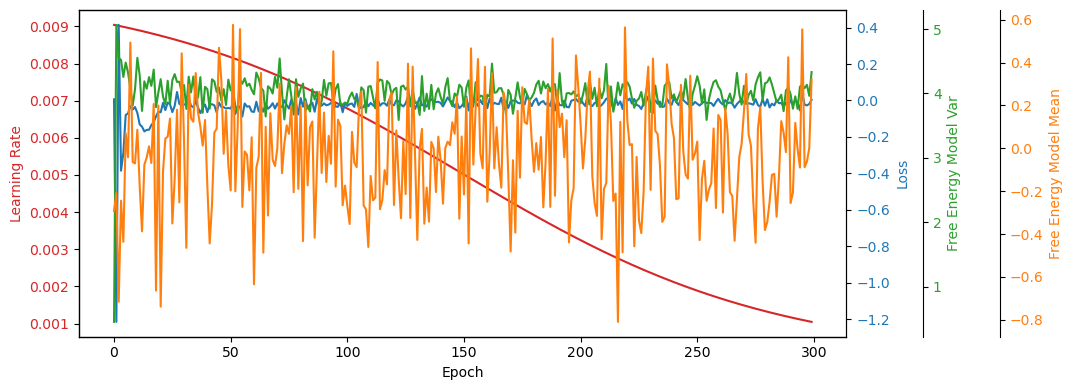

In [7]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [8]:
# CELL 7
@torch.no_grad()
def compute_renyi_entropy(model: ConditionalRBM, h: float, max_ell: int, num_samples: int = 10000):
    """
    2nd Renyi Entropy via Simple Replica Trick for subsystem sizes l=1..max_ell.
    """
    device = next(model.parameters()).device
    model.eval()

    # we need conditioning vector and modulated biases for later free energy calculations
    cond = torch.full((num_samples, 1), float(h), device=device, dtype=torch.float32)

    # we compute this once since h is constant for the batch
    gamma_b, beta_b, gamma_c, beta_c = model.conditioner(cond)
    b_mod = (1.0 + gamma_b) * model.b.unsqueeze(0) + beta_b
    c_mod = (1.0 + gamma_c) * model.c.unsqueeze(0) + beta_c

    # generate replica 1 and replica 2
    T_schedule = torch.full((model.k,), model.T, device=device)
    gen = torch.Generator(device=device).manual_seed(12345)
    s1 = model.generate(cond, T_schedule, gen)
    s2 = model.generate(cond, T_schedule, gen)

    results = []

    # pre-calculate Free Energies of original configurations
    # Recall: psi(v) is proportional to exp(-FreeEnergy(v) / 2) so log_psi(v) = -FreeEnergy(v) / 2
    F1 = model._free_energy(s1, model.W, b_mod, c_mod)
    F2 = model._free_energy(s2, model.W, b_mod, c_mod)

    # denominator in log space: log(psi(s1)) + log(psi(s2)) = -0.5 * (F1 + F2)
    log_denom = -0.5 * (F1 + F2)

    print(f"Calculating Renyi Entropy for h={h}...")

    for ell in range(1, max_ell + 1):
        # swap the first ell bits between s1 and s2 like a genetic crossover
        s1_swap = s1.clone()
        s2_swap = s2.clone()

        s1_swap[:, :ell] = s2[:, :ell]
        s2_swap[:, :ell] = s1[:, :ell]

        # same free energy denominator as before
        F1_swap = model._free_energy(s1_swap, model.W, b_mod, c_mod)
        F2_swap = model._free_energy(s2_swap, model.W, b_mod, c_mod)

        log_num = -0.5 * (F1_swap + F2_swap)

        # calculate ratio in log space to avoid numerical issues
        log_ratio = log_num - log_denom
        ratio = torch.exp(log_ratio)

        # expectation value over whole batch
        swap_expectation = ratio.mean()

        # S2 = -log(<Swap>)
        s2_val = -torch.log(swap_expectation).item()
        results.append(s2_val)

    return results

In [9]:
h_eval_values = [0.8, 1.0, 1.2]
max_subsystem = 8 # half of num_visible
n_renyi_samples = 20000

rbm_data = {}

for h_val in h_eval_values:
    s2_curve = compute_renyi_entropy(model, h_val, max_subsystem, n_renyi_samples)
    rbm_data[h_val] = s2_curve
    print(f"h={h_val}: {s2_curve}")

Calculating Renyi Entropy for h=0.8...
h=0.8: [0.5148692727088928, 0.6303297281265259, 0.6703446507453918, 0.6925833821296692, 0.7055030465126038, 0.7117225527763367, 0.7118716239929199, 0.7139723896980286]
Calculating Renyi Entropy for h=1.0...
h=1.0: [0.34761035442352295, 0.44038721919059753, 0.48474347591400146, 0.5379594564437866, 0.5453636646270752, 0.575369656085968, 0.5822910666465759, 0.5751824378967285]
Calculating Renyi Entropy for h=1.2...
h=1.2: [0.21392065286636353, 0.26328977942466736, 0.2806115448474884, 0.2926742732524872, 0.2963063418865204, 0.2976868152618408, 0.2898271083831787, 0.29719454050064087]


Reference data loaded successfully.


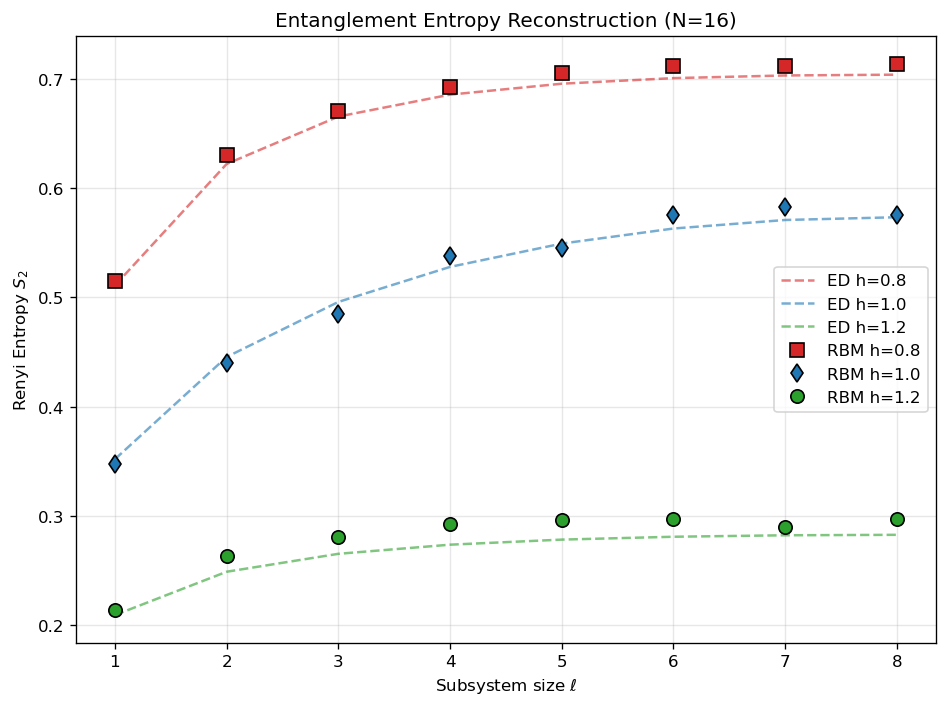

In [10]:
import pandas as pd

# load reference data or just leave empty if not available
ref_file = "tfim_16_renyi_ref.csv"
try:
    df_ref = pd.read_csv(ref_file)
    l_axis = df_ref["l"].values

    ref_curves = {
        0.8: df_ref["S2_h0.8"].values,
        1.0: df_ref["S2_h1.0"].values,
        1.2: df_ref["S2_h1.2"].values
    }
    print("Reference data loaded successfully.")
except Exception as e:
    print(f"Could not load reference file: {e}")
    # Fallback if file missing
    l_axis = list(range(1, max_subsystem + 1))
    ref_curves = {}

plt.figure(figsize=(8, 6), dpi=120)

styles = {
    0.8: {'color': 'tab:red',   'fmt': 's', 'label': 'h=0.8'},
    1.0: {'color': 'tab:blue',  'fmt': 'd', 'label': 'h=1.0'},
    1.2: {'color': 'tab:green', 'fmt': 'o', 'label': 'h=1.2'}
}

for h, s2_vals in ref_curves.items():
    c = styles[h]['color']
    plt.plot(l_axis, s2_vals, linestyle='--', color=c, alpha=0.6, label=f"ED {styles[h]['label']}")

l_rbm = range(1, max_subsystem + 1)
for h, s2_vals in rbm_data.items():
    style = styles[h]
    plt.plot(l_rbm, s2_vals, marker=style['fmt'], linestyle='None',
             color=style['color'], markersize=8, markeredgecolor='k',
             label=f"RBM {style['label']}")

plt.xlabel(r"Subsystem size $\ell$")
plt.ylabel(r"Renyi Entropy $S_2$")
plt.title(f"Entanglement Entropy Reconstruction (N={num_visible})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(l_rbm)
plt.tight_layout()
plt.show()